# Example Run
This following is a teaser of the library to show basic functionality and getting familiarized with it. Due to the high computational demands of computing the actual compositions however, it's recommended that for that part you follow the methods suggested in the `README.md` file.

In [8]:
import os

os.environ["PROJECT_DIR"] = "/Users/idansegal/Documents/Coding/AnnoTransfer"
os.chdir(os.environ["PROJECT_DIR"])
print("Project directory set to:", os.getcwd())

from pathlib import Path
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_auc_score, pairwise_distances, accuracy_score
import torch
import torch.optim as optim
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import scipy.sparse as sp
from numba import jit
from Annotatability import models
from Annotatability import metrics
import scvi
import logging
import squidpy as sq
import contextlib
import io
import random
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder  # Added imports
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
from Scripts.annotatability_automations import *
logging.getLogger("scvi").setLevel(logging.WARNING)

SMALL_SIZE = 16
MEDIUM_SIZE = 20.5
BIGGER_SIZE = 24
#plt.rcParams["font.family"] = "Verdana"
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
sc.set_figure_params(scanpy=True, fontsize=20.5)

# Define custom color palette
annotation_order = ['Easy-to-learn', 'Ambiguous', 'Hard-to-learn']
annotation_colors = ['green', 'orange', 'red']
palette = dict(zip(annotation_order, annotation_colors))

Project directory set to: /Users/idansegal/Documents/Coding/AnnoTransfer


## Annotating the dataset

In [9]:
# we'll choose the merfish dataset. Like the rest of the datasets in this library, 
# all its configurations such as batch size are stored in Datasets/<dataset_name>.py
dataset = get_dataset("merfish")
adata = annotate("merfish") # here we find for it the easy, ambiguous and hard-to-learn annotations

2025-02-15 08:59:44,203 - INFO - Existing cell types: 
2025-02-15 08:59:44,205 - INFO - Cell_class
Inhibitory       24761
Excitatory       11757
Ambiguous         9269
Astrocyte         8393
OD Mature 2       5736
Endothelial 1     3799
OD Immature 1     2457
Ependymal         1961
Microglia         1472
Endothelial 3     1369
OD Mature 1        952
Pericytes          638
Endothelial 2      581
OD Mature 4        367
OD Immature 2       91
OD Mature 3         39
Name: count, dtype: int64
2025-02-15 08:59:44,210 - INFO - Transformed to: 
2025-02-15 08:59:44,212 - INFO - CellType
Inhibitory     24761
Excitatory     11757
Ambiguous       9269
Astrocyte       8393
OD Mature       7094
Endothelial     5749
OD Immature     2548
Ependymal       1961
Microglia       1472
Pericytes        638
Name: count, dtype: int64


2025-02-15 08:59:44,261 - INFO - Existing cell types: 
2025-02-15 08:59:44,262 - INFO - Cell_class
Inhibitory       24761
Excitatory       11757
Ambiguous         9269
Astrocyte         8393
OD Mature 2       5736
Endothelial 1     3799
OD Immature 1     2457
Ependymal         1961
Microglia         1472
Endothelial 3     1369
OD Mature 1        952
Pericytes          638
Endothelial 2      581
OD Mature 4        367
OD Immature 2       91
OD Mature 3         39
Name: count, dtype: int64
2025-02-15 08:59:44,267 - INFO - Transformed to: 
2025-02-15 08:59:44,270 - INFO - CellType
Inhibitory     24761
Excitatory     11757
Ambiguous       9269
Astrocyte       8393
OD Mature       7094
Endothelial     5749
OD Immature     2548
Ependymal       1961
Microglia       1472
Pericytes        638
Name: count, dtype: int64
2025-02-15 08:59:44,270 - INFO - Starting annotation process...
2025-02-15 08:59:44,388 - INFO - Existing cell types: 
2025-02-15 08:59:44,389 - INFO - Cell_class
Inhibitory      

2025-02-15 08:59:44,444 - INFO - Existing cell types: 
2025-02-15 08:59:44,445 - INFO - Cell_class
Inhibitory       24761
Excitatory       11757
Ambiguous         9269
Astrocyte         8393
OD Mature 2       5736
Endothelial 1     3799
OD Immature 1     2457
Ependymal         1961
Microglia         1472
Endothelial 3     1369
OD Mature 1        952
Pericytes          638
Endothelial 2      581
OD Mature 4        367
OD Immature 2       91
OD Mature 3         39
Name: count, dtype: int64
2025-02-15 08:59:44,451 - INFO - Transformed to: 
2025-02-15 08:59:44,453 - INFO - CellType
Inhibitory     24761
Excitatory     11757
Ambiguous       9269
Astrocyte       8393
OD Mature       7094
Endothelial     5749
OD Immature     2548
Ependymal       1961
Microglia       1472
Pericytes        638
Name: count, dtype: int64
2025-02-15 08:59:44,549 - INFO - Loaded existing annotated dataset.


## Calculating the Optimal Compositions

In [10]:
label_key = dataset.label_key
epoch_num_annot = dataset.epoch_num_annot
epoch_num_composition = dataset.epoch_num_composition
swap_probability = dataset.swap_probability
percentile = dataset.percentile
batch_size = dataset.batch_size
format_manager = dataset.manager

# we'll use very small sizes here to speed up the process since this is just an example, therefore our results will not be meaningful
repeats_per_size = 2
train_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
best_compositions, label_encoder = find_optimal_compositions('merfish', adata, label_key, train_sizes, 
                        repeats_per_size, device, epoch_num_composition, batch_size, format_manager)

2025-02-15 08:59:44,555 - INFO - Starting find_optimal_compositions for dataset: merfish
2025-02-15 08:59:44,557 - INFO - Loading existing results from merfish_optimal_compositions.csv
2025-02-15 08:59:44,562 - INFO - Group counts in the data: {'Ambiguous': 42077, 'Easy-to-learn': 23555, 'Hard-to-learn': 8010}
2025-02-15 08:59:44,566 - INFO - Using cached result for merfish Train_Size=10: Easy=4, Ambiguous=6, Hard=0, Test Loss=1.12257981300354
2025-02-15 08:59:44,566 - INFO - Using cached result for merfish Train_Size=10: Easy=3, Ambiguous=5, Hard=2, Test Loss=0.9712767601013184
2025-02-15 08:59:44,567 - INFO - Using cached result for merfish Train_Size=20: Easy=3, Ambiguous=16, Hard=1, Test Loss=1.2134993076324463
2025-02-15 08:59:44,567 - INFO - Using cached result for merfish Train_Size=20: Easy=3, Ambiguous=3, Hard=14, Test Loss=1.2285937070846558
2025-02-15 08:59:44,567 - INFO - Using cached result for merfish Train_Size=30: Easy=6, Ambiguous=13, Hard=11, Test Loss=1.1585085391998

## Analysis

2025-02-15 08:59:44,583 - INFO - Starting visualization of optimal compositions...
2025-02-15 08:59:44,585 - INFO - Loaded results from merfish_optimal_compositions.csv
2025-02-15 08:59:44,592 - INFO - Creating plot for optimal compositions...
2025-02-15 08:59:44,885 - INFO - Visualization saved as optimal_compositions.png


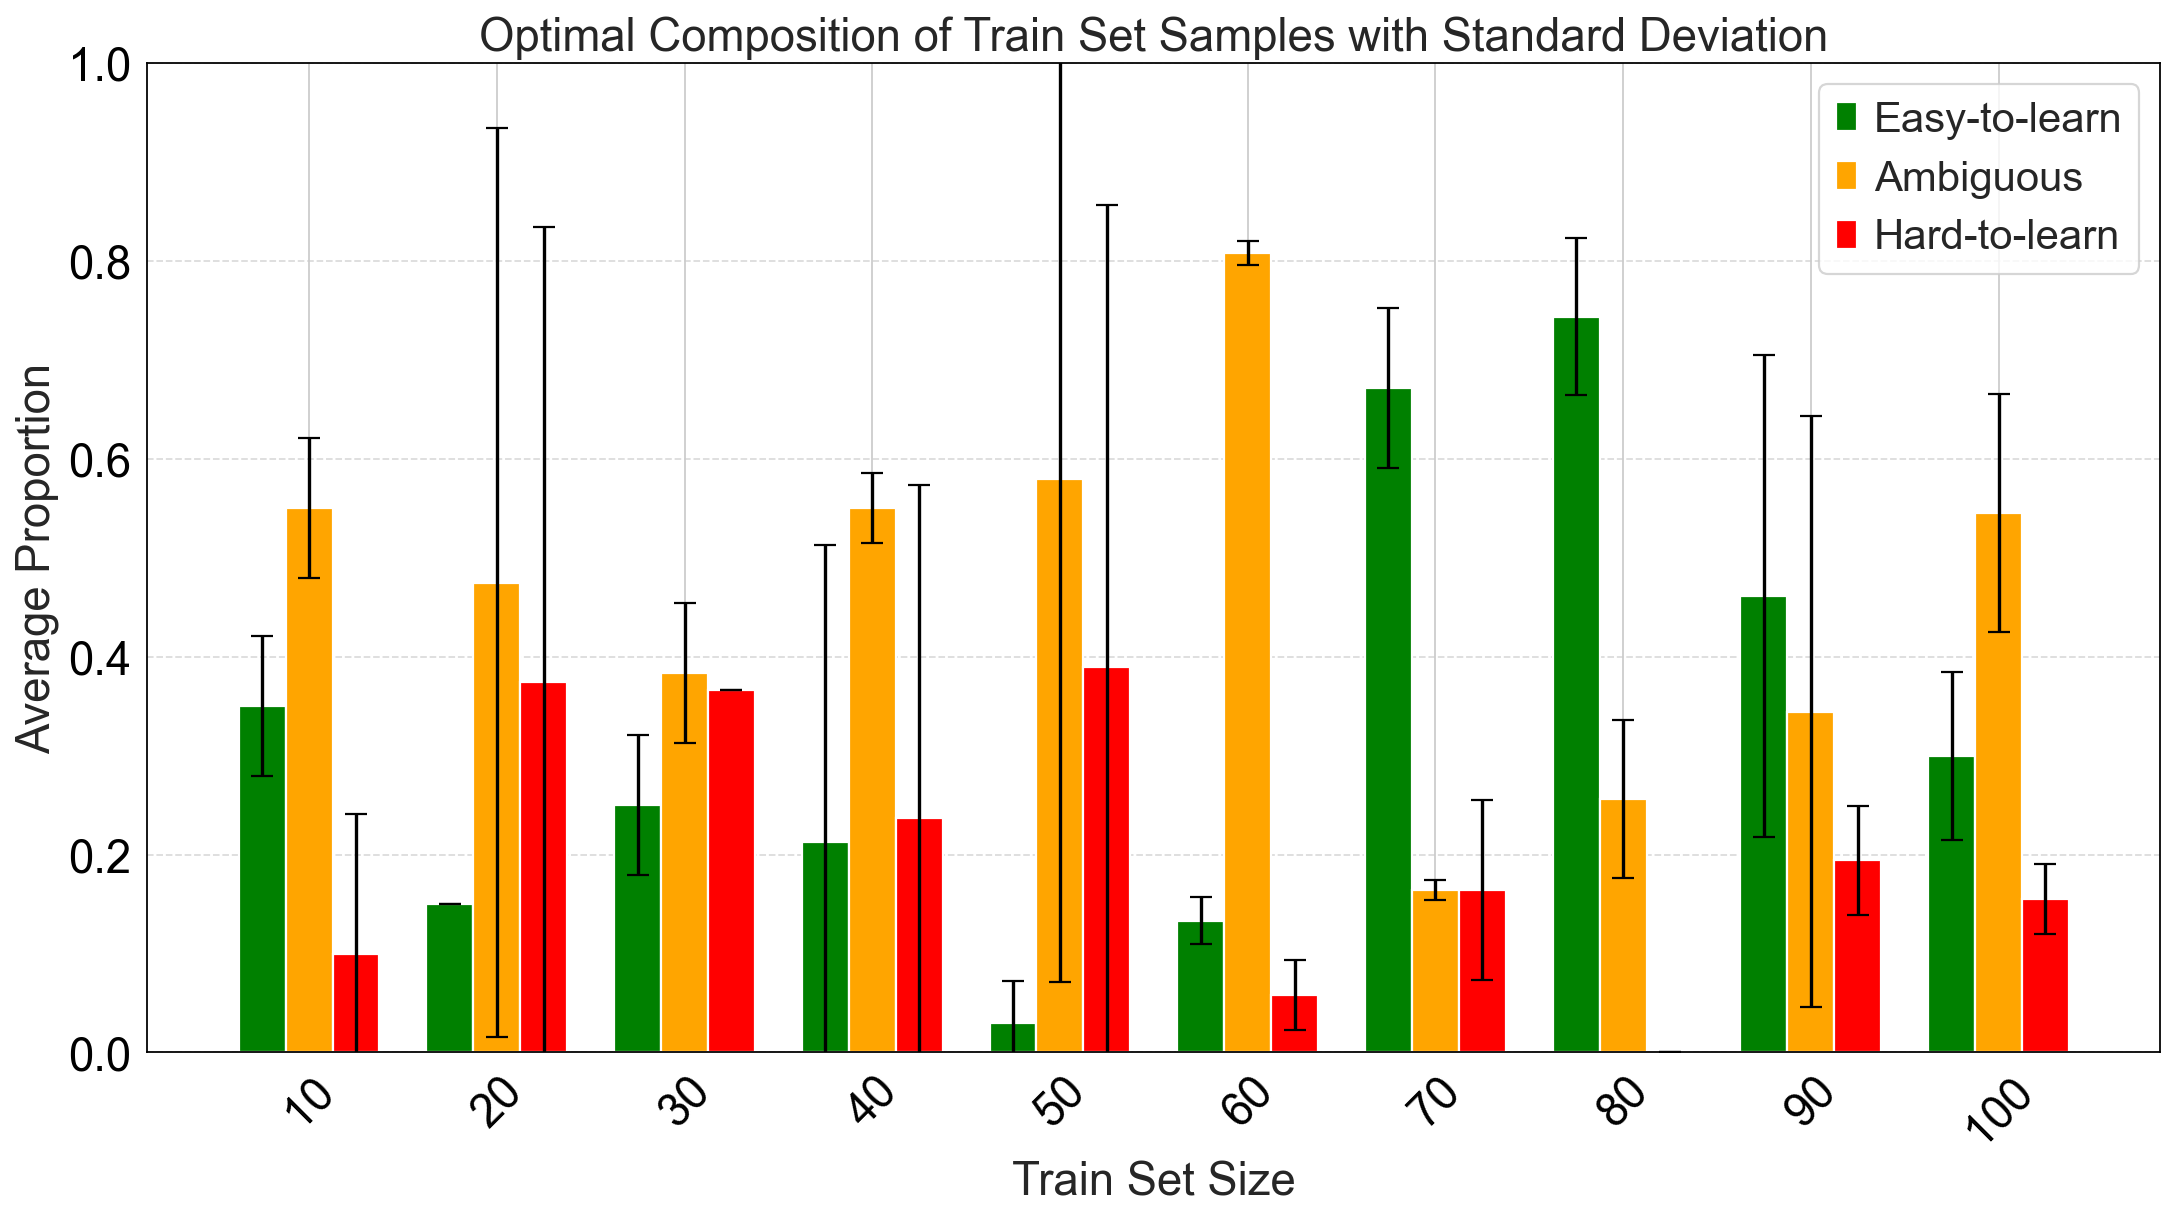

In [11]:
visualize_optimal_compositions_with_std('merfish')

/Users/idansegal/Documents/Coding/AnnoTransfer/annot_venv/bin/python
/Library/Frameworks/Python.framework/Versions/3.9/lib/python39.zip
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/lib-dynload

/Users/idansegal/Documents/Coding/AnnoTransfer/annot_venv/lib/python3.9/site-packages


<Figure size 960x480 with 0 Axes>

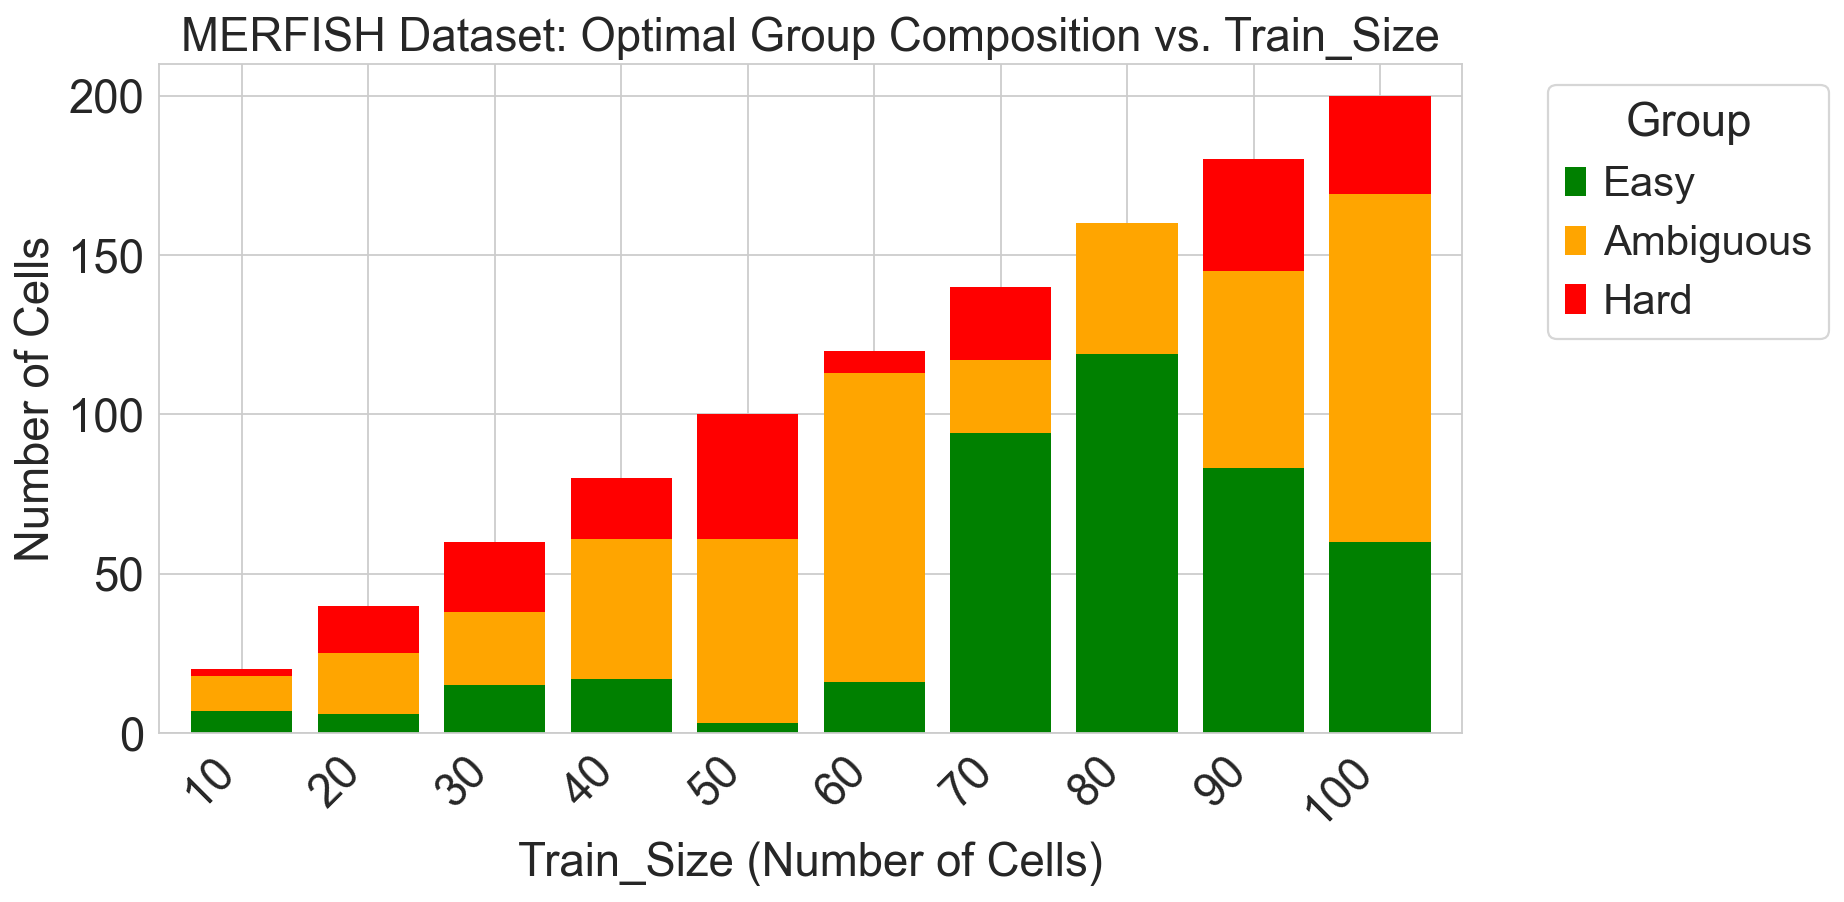

In [12]:
import importlib
import Scripts.annotatability_automations as aa
importlib.reload(aa)
aa.visualize_optimal_compositions_stacked_bar(dataset_name='merfish')

2025-02-15 08:59:45,621 - INFO - Starting processing of highest confidence samples...
2025-02-15 08:59:45,636 - INFO - Processing high-confidence composition for Train_Size=10
2025-02-15 08:59:45,704 - INFO - Train_Size=10, Test Loss=1.1314712762832642
2025-02-15 08:59:45,705 - INFO - Processing high-confidence composition for Train_Size=20
2025-02-15 08:59:45,771 - INFO - Train_Size=20, Test Loss=1.5354423522949219
2025-02-15 08:59:45,772 - INFO - Processing high-confidence composition for Train_Size=30
2025-02-15 08:59:45,836 - INFO - Train_Size=30, Test Loss=1.3405991792678833
2025-02-15 08:59:45,837 - INFO - Processing high-confidence composition for Train_Size=40
2025-02-15 08:59:45,917 - INFO - Train_Size=40, Test Loss=1.8253364562988281
2025-02-15 08:59:45,917 - INFO - Processing high-confidence composition for Train_Size=50
2025-02-15 08:59:45,984 - INFO - Train_Size=50, Test Loss=1.8262028694152832
2025-02-15 08:59:45,985 - INFO - Processing high-confidence composition for Tra

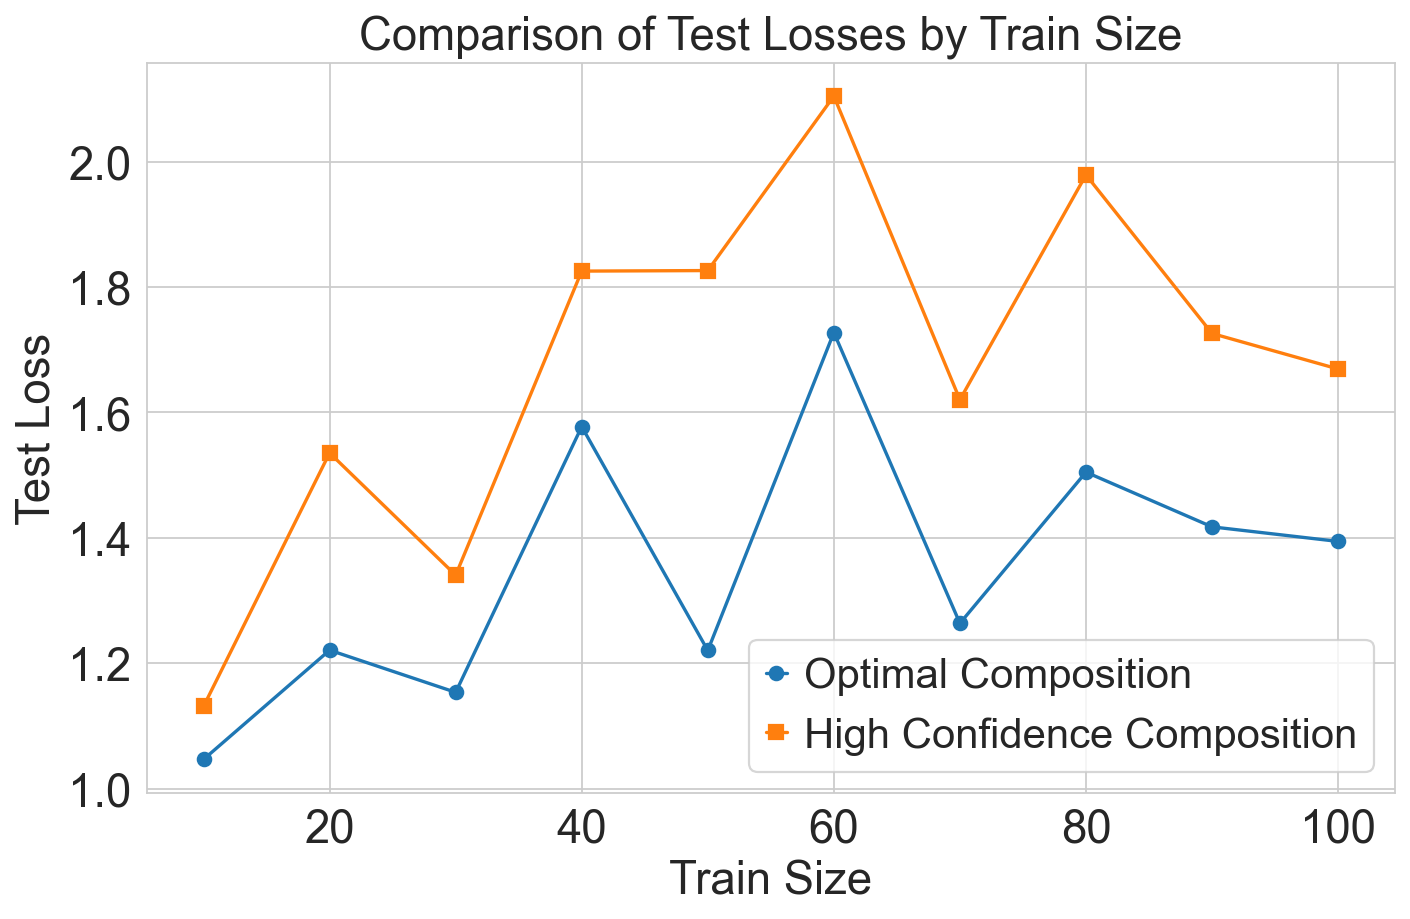

In [13]:
aa.highest_confidence_samples(adata, train_sizes, device, label_encoder, 'merfish', label_key)

### Distribution of cell types among annotatability

In [14]:
distribution = pd.crosstab(adata.obs['CellType'], adata.obs['Annotation'])
distribution_percentage = distribution.apply(lambda row: row / row.sum() * 100, axis=1)

print(f"Label distribution")
print(distribution)

print("\nPercentage distribution %")
print(distribution_percentage.round(2))

Label distribution
Annotation   Ambiguous  Easy-to-learn  Hard-to-learn
CellType                                            
Ambiguous         6209            456           2604
Astrocyte         3081           5048            264
Endothelial       1756           3946             47
Ependymal          122           1839              0
Excitatory        7700           2646           1411
Inhibitory       19892           1323           3546
Microglia          339           1133              0
OD Immature        861           1687              0
OD Mature         2031           4925            138
Pericytes           86            552              0

Percentage distribution %
Annotation   Ambiguous  Easy-to-learn  Hard-to-learn
CellType                                            
Ambiguous        66.99           4.92          28.09
Astrocyte        36.71          60.15           3.15
Endothelial      30.54          68.64           0.82
Ependymal         6.22          93.78           0.00
